# Discrete A/B Test

Prior Distribution:
- A Beta prior with parameters \(\alpha_{\text{prior}} = 1\) and \(\beta_{\text{prior}} = 1\), representing a uniform distribution (non-informative prior).

Posterior Distribution:
- Posterior parameters for the Beta distribution are calculated as follows:

$$
\alpha_{\text{post}} = \alpha_{\text{prior}} + \text{successes}
$$

$$
\beta_{\text{post}} = \beta_{\text{prior}} + (\text{trials} - \text{successes})
$$

Bayes Factor:
- The Bayes Factor is calculated to quantify the evidence in favor of the control group having a better conversion rate than the treatment group:

$$
\text{BF} = \frac{P(\text{control\_samples} > \text{treatment\_samples})}{P(\text{control\_samples} \leq \text{treatment\_samples})}
$$

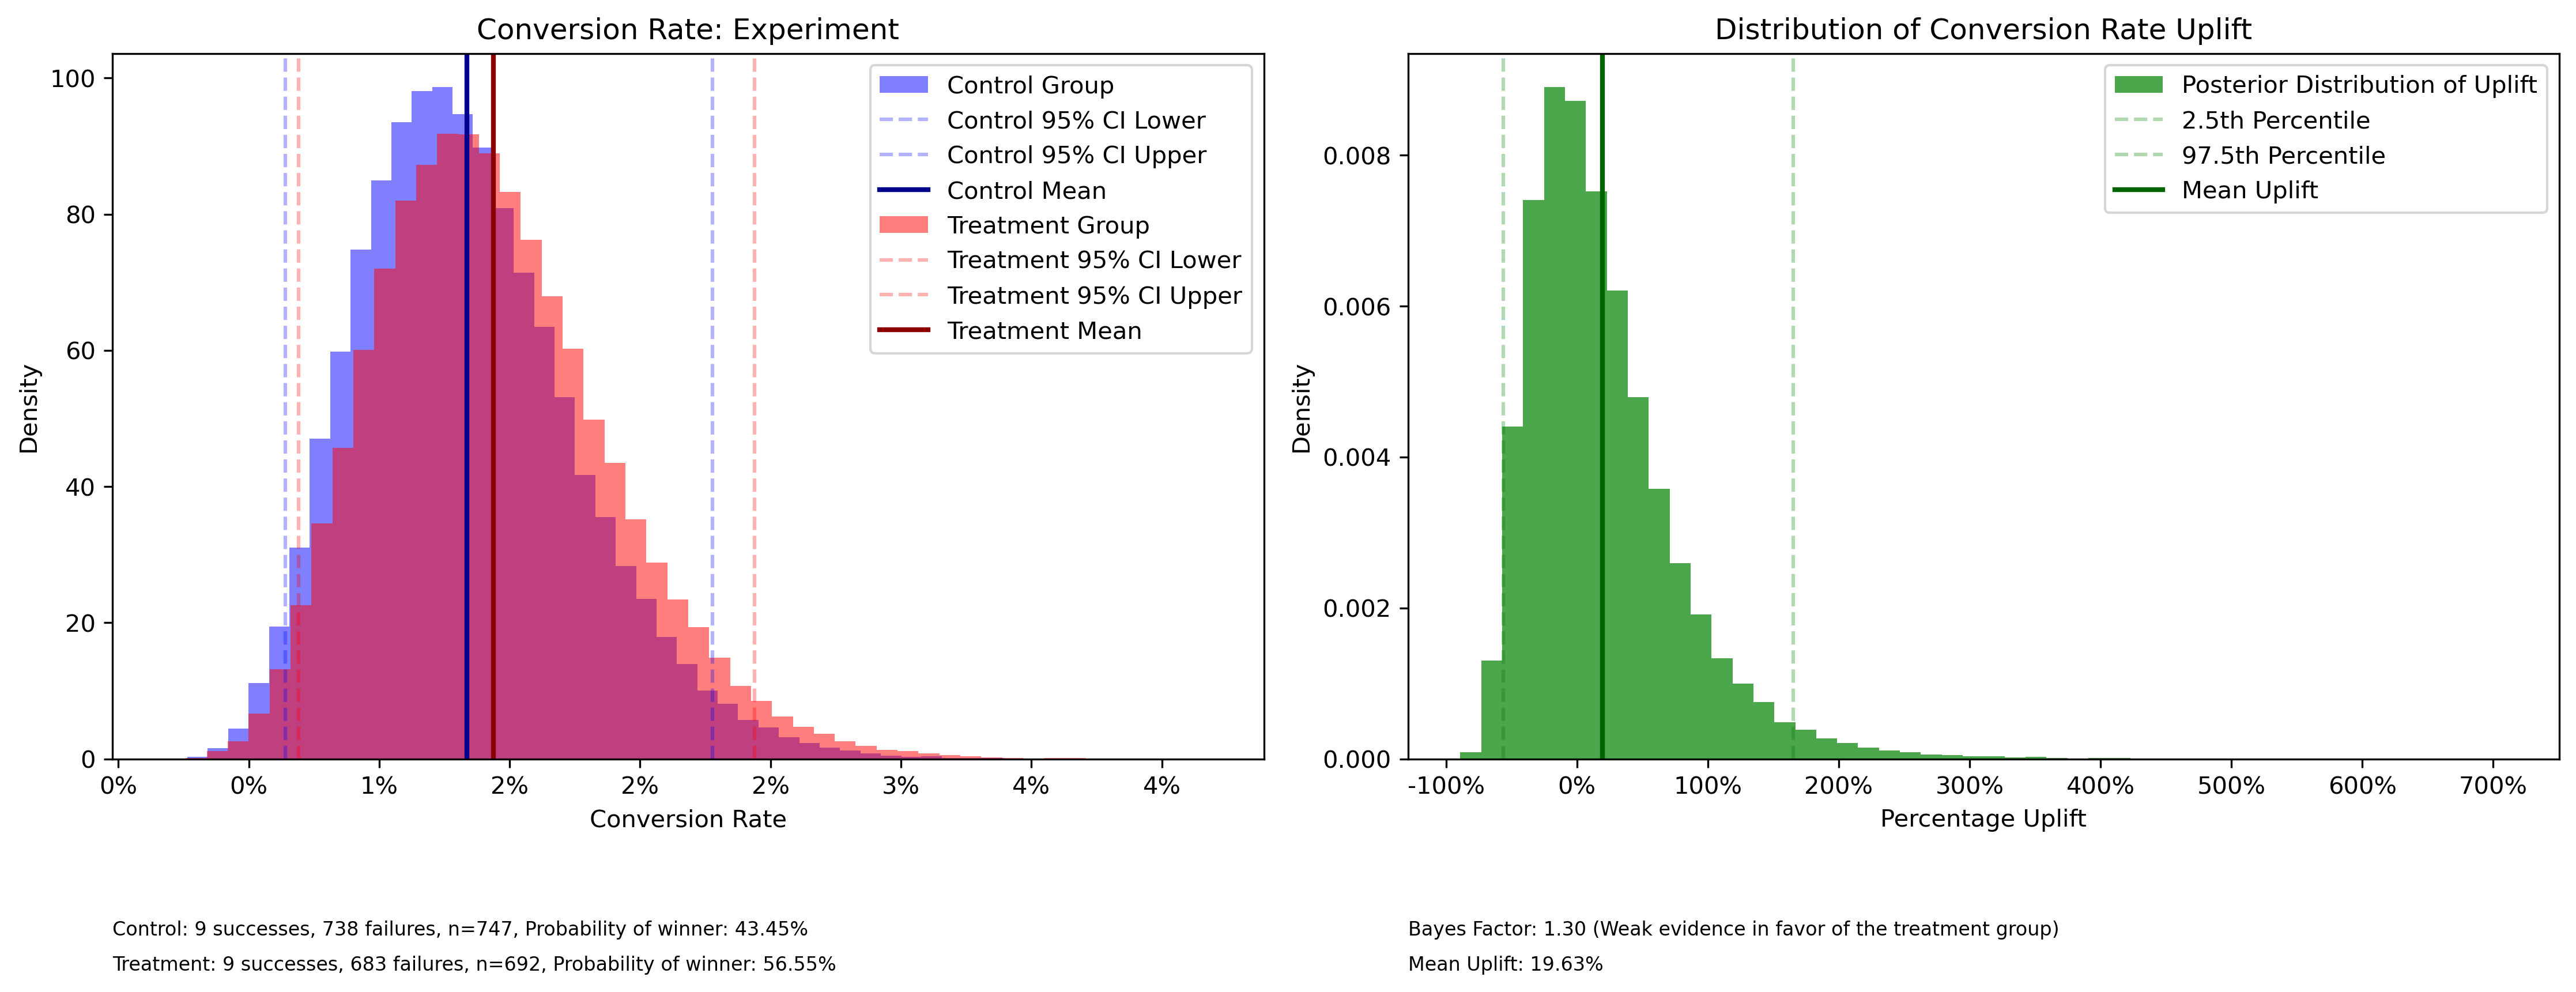

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_posterior_params(alpha_prior, beta_prior, successes, trials):
    alpha_post = alpha_prior + successes
    beta_post = beta_prior + (trials - successes)
    return alpha_post, beta_post

def sample_beta_distribution(alpha_post, beta_post, num_samples):
    return np.random.beta(alpha_post, beta_post, num_samples)

def calculate_credible_intervals(samples):
    return np.percentile(samples, [2.5, 97.5])

def calculate_overlap_ratio(interval1, interval2):
    a, b = interval1
    c, d = interval2

    overlap_start = max(a, c)
    overlap_end = min(b, d)

    if overlap_start >= overlap_end:
        return 0.0  # No overlap

    overlap_length = overlap_end - overlap_start
    interval_length = b - a

    return overlap_length / interval_length

def calculate_bayes_factor(samples_control, samples_treatment):
    prob_treatment_better = np.mean(samples_treatment > samples_control)
    prob_control_better = 1 - prob_treatment_better
    return prob_treatment_better / prob_control_better

def interpret_bayes_factor(bf):
    if bf < 1:
        return bf, "control"
    return bf, "treatment"

def interpret_bayes_factor_label(bf):
    if bf < 1:
        return "Error"
    elif 1 <= bf < 3:
        return "Weak evidence"
    elif 3 <= bf < 10:
        return "Moderate evidence"
    elif 10 <= bf < 30:
        return "Strong evidence"
    elif 30 <= bf < 100:
        return "Very strong evidence"
    else:
        return "Decisive evidence"

def plot_distributions(control_samples, treatment_samples, control_credible_intervals, treatment_credible_intervals, control_mean, treatment_mean, target_variable):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=300)

    axs[0].hist(control_samples, bins=50, alpha=0.5, label='Control Group', color='blue', density=True)
    axs[0].axvline(x=control_credible_intervals[0], color='blue', linestyle='--', alpha=0.3, label='Control 95% CI Lower')
    axs[0].axvline(x=control_credible_intervals[1], color='blue', linestyle='--', alpha=0.3, label='Control 95% CI Upper')
    axs[0].axvline(x=control_mean, color='darkblue', linestyle='-', linewidth=2, label='Control Mean')

    axs[0].hist(treatment_samples, bins=50, alpha=0.5, label='Treatment Group', color='red', density=True)
    axs[0].axvline(x=treatment_credible_intervals[0], color='red', linestyle='--', alpha=0.3, label='Treatment 95% CI Lower')
    axs[0].axvline(x=treatment_credible_intervals[1], color='red', linestyle='--', alpha=0.3, label='Treatment 95% CI Upper')
    axs[0].axvline(x=treatment_mean, color='darkred', linestyle='-', linewidth=2, label='Treatment Mean')

    axs[0].set_xlabel(f'{target_variable}')
    axs[0].set_ylabel('Density')
    axs[0].set_title(f'{target_variable}: Experiment')
    axs[0].legend()

    axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

    return fig, axs

def add_annotations(ax, control_text, treatment_text, bayes_factor_text, uplift_text):
    ax.annotate(control_text, xy=(0, -0.25), xycoords='axes fraction', fontsize=8, ha='left')
    ax.annotate(treatment_text, xy=(0, -0.30), xycoords='axes fraction', fontsize=8, ha='left')
    ax.annotate(bayes_factor_text, xy=(0, -0.25), xycoords='axes fraction', fontsize=8, ha='left')
    ax.annotate(uplift_text, xy=(0, -0.30), xycoords='axes fraction', fontsize=8, ha='left')

def main():
    # Input data
    alpha_prior = 1
    beta_prior = 1
    control_successes = 9
    control_trials = 747
    treatment_successes = 9
    treatment_trials = 692
    target_variable = 'Conversion Rate'
    num_samples = 100000

    # Calculate posterior parameters and sample from Beta distributions
    alpha_post_control, beta_post_control = calculate_posterior_params(alpha_prior, beta_prior, control_successes, control_trials)
    alpha_post_treatment, beta_post_treatment = calculate_posterior_params(alpha_prior, beta_prior, treatment_successes, treatment_trials)
    
    control_samples = sample_beta_distribution(alpha_post_control, beta_post_control, num_samples)
    treatment_samples = sample_beta_distribution(alpha_post_treatment, beta_post_treatment, num_samples)
    
    control_mean = np.mean(control_samples)
    treatment_mean = np.mean(treatment_samples)
    
    control_credible_intervals = calculate_credible_intervals(control_samples)
    treatment_credible_intervals = calculate_credible_intervals(treatment_samples)
    
    overlap_ratio = calculate_overlap_ratio(control_credible_intervals, treatment_credible_intervals)
    
    bf_10 = calculate_bayes_factor(control_samples, treatment_samples)
    bf_01 = 1 / bf_10
    
    if bf_10 > 1:
        bayes_factor = bf_10
        leading_group = "treatment"
    else:
        bayes_factor = bf_01
        leading_group = "control"
    
    bayes_factor_interpretation = interpret_bayes_factor_label(bayes_factor)
    
    chance_treatment_better = np.mean(treatment_samples > control_samples)
    chance_control_better = 1 - chance_treatment_better
    
    uplift = (treatment_samples / control_samples - 1) * 100
    if np.mean(uplift) < 0:
        uplift = (control_samples / treatment_samples - 1) * 100
    
    positive_uplift_percentage = np.mean(uplift > 0) * 100
    mean_uplift = np.mean(uplift)

    # Plot distributions and annotations
    fig, axs = plot_distributions(control_samples, treatment_samples, control_credible_intervals, treatment_credible_intervals, control_mean, treatment_mean, target_variable)
    
    axs[1].hist(uplift, bins=50, alpha=0.7, label='Posterior Distribution of Uplift', color='green', density=True)
    axs[1].axvline(x=np.percentile(uplift, 2.5), color='green', linestyle='--', alpha=0.3, label='2.5th Percentile')
    axs[1].axvline(x=np.percentile(uplift, 97.5), color='green', linestyle='--', alpha=0.3, label='97.5th Percentile')
    axs[1].axvline(x=mean_uplift, color='darkgreen', linestyle='-', linewidth=2, label='Mean Uplift')
    axs[1].set_xlabel('Percentage Uplift')
    axs[1].set_ylabel('Density')
    axs[1].set_title(f'Distribution of {target_variable} Uplift')
    axs[1].legend()
    axs[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    
    control_text = f'Control: {control_successes} successes, {control_trials - control_successes} failures, n={control_trials}, Probability of winner: {chance_control_better*100:.2f}%'
    treatment_text = f'Treatment: {treatment_successes} successes, {treatment_trials - treatment_successes} failures, n={treatment_trials}, Probability of winner: {chance_treatment_better*100:.2f}%'
    bayes_factor_text = f"Bayes Factor: {bayes_factor:.2f} ({bayes_factor_interpretation} in favor of the {leading_group} group)"
    uplift_text = f"Mean Uplift: {mean_uplift:.2f}%"
    
    add_annotations(axs[0], control_text, treatment_text, "", "")
    add_annotations(axs[1], "", "", bayes_factor_text, uplift_text)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

# Presentation

- **Introduction to Growth Teams**
  - The purpose of growth teams is to grow revenue.
    - Make sure your CEO actually wants to grow revenue (FCF from a ponzi scheme)
    - Revenue as price * volume.
    - LTV as a a combination of Traffic, conversion rate, land ARPA, expansion rate, and retention rate.
    - North star of a growth team will necessarily end up being a conversion rate, an expansion rate, retention rate, or a price.

- **Understanding Revenue and Key Metrics**
  - The hierarchy of target variables (necessary, causal, correlation).
    - The problem with activation metrics (and product usage variables).
  - Conversion rates as target variables.
  - Revenues or prices as target variables.
    - Distributions of payoffs.
    - Fat-tailed payoffs.
    - Jensen's inequality

- **Basics of A/B Testing**
  - The purpose of A/B testing is to establish which actions cause revenue.
    - Three types of relationships: Necessity (tautology), causality (do operator), spurious correlation (common cause).
  - A/B testing is the only way to differentiate between causality and spurious correlation.
  - Randomizing controls for confounds by the Law of Large Numbers (LLN) – even distribution of confounds.
  - The word 'Uplift' necessarily makes a statement about causality.

- **Sample Size and Statistical Power**
  - Addressing 'We don't have enough sample size' concerns.
    - Exploration vs exploitation
          - Type I errors don't matter.
    - Minimum detectable effect.
    - Minimum posterior precision.


- **Frequentist vs. Bayesian A/B Testing**
  - Bayesian A/B testing is superior to frequentist A/B testing.
    - Superior for stakeholders:
      - Allows us to make statements about probabilities rather than error rates.
      - Aligns with human intuitions about statistics.
    - Superior mathematically:
      - TBD (To Be Determined).

- **Interpreting Bayesian Tests**
  - Posteriors and posterior precision.
  - Point estimates: means and MAP
  - Probability of win.
  - Bayes factors.
  - Effect sizes (and practical significance).
  - 'What causes this result?'

- **Financial value of a test**
  - Incremental LTV generated, all else equal.


- **Advanced Testing Methods**
  - ABCD tests (multiple comparisons in a Bayesian world - Bayesian Model Averaging)
  - Weird things:
    - Peeking.

- **Technological Implementation**
  - Automating an experimentation program.
  - Bayesian testing requires Monte Carlo sampling (more than SQL, at a minimum).
    - MCMC, variational inference, and all that jazz.

The best variant is B with a posterior probability of 0.9137
Posterior probabilities of each variant being the best:
Variant A: 0.0430
Variant B: 0.9137
Variant C: 0.0001
Variant D: 0.0432


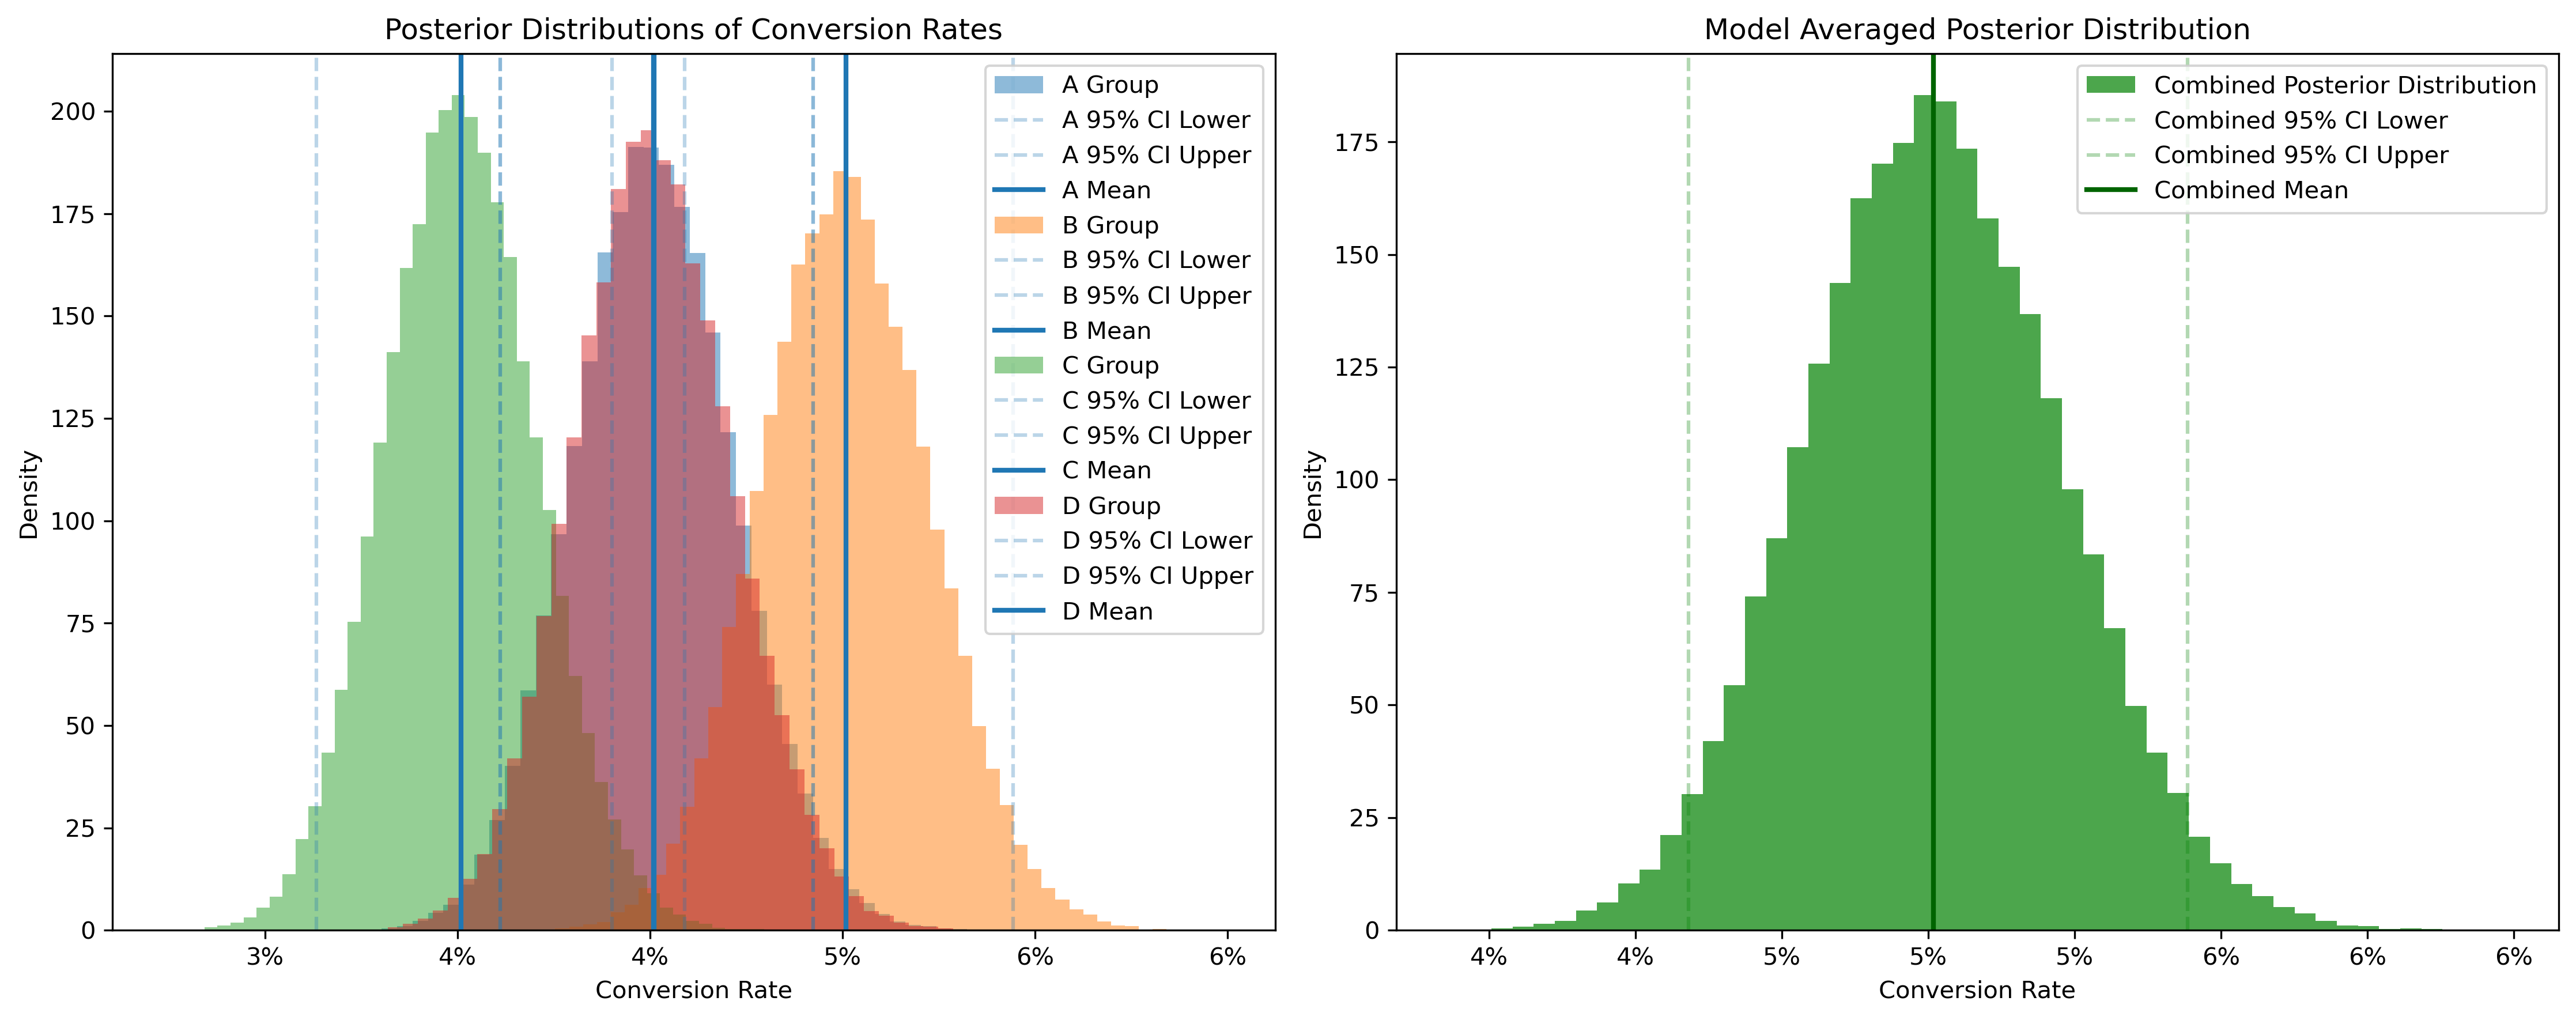

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import loggamma

def calculate_posterior_params(alpha_prior, beta_prior, successes, trials):
    alpha_post = alpha_prior + successes
    beta_post = beta_prior + (trials - successes)
    return alpha_post, beta_post

def sample_beta_distribution(alpha_post, beta_post, num_samples):
    return np.random.beta(alpha_post, beta_post, num_samples)

def calculate_log_marginal_likelihood(alpha_prior, beta_prior, successes, trials):
    alpha_post = alpha_prior + successes
    beta_post = beta_prior + (trials - successes)
    log_marginal_likelihood = (
        loggamma(alpha_post + beta_post) - loggamma(alpha_post) - loggamma(beta_post)
        + loggamma(alpha_prior) + loggamma(beta_prior) - loggamma(alpha_prior + beta_prior)
    )
    return log_marginal_likelihood

def calculate_model_posterior_probabilities(log_marginal_likelihoods, model_priors):
    log_unnormalized_posteriors = {model: log_marginal_likelihoods[model] + np.log(model_priors[model]) for model in log_marginal_likelihoods}
    max_log_posterior = max(log_unnormalized_posteriors.values())
    log_normalized_posteriors = {model: log_unnormalized_posteriors[model] - max_log_posterior for model in log_unnormalized_posteriors}
    exp_normalized_posteriors = {model: np.exp(log_normalized_posteriors[model]) for model in log_normalized_posteriors}
    normalization_constant = sum(exp_normalized_posteriors.values())
    return {model: exp_normalized_posteriors[model] / normalization_constant for model in exp_normalized_posteriors}

def calculate_best_variant_posterior_probs(samples_dict):
    variant_probs = {variant: 0 for variant in samples_dict.keys()}
    num_samples = len(next(iter(samples_dict.values())))
    
    for i in range(num_samples):
        best_variant = max(samples_dict.keys(), key=lambda variant: samples_dict[variant][i])
        variant_probs[best_variant] += 1
    
    for variant in variant_probs:
        variant_probs[variant] /= num_samples
    
    return variant_probs

def main():
    # Input data
    alpha_prior = 1
    beta_prior = 1
    successes = {'A': 450, 'B': 500, 'C': 400, 'D': 450}
    trials = {'A': 10000, 'B': 10000, 'C': 10000, 'D': 10000}
    num_samples = 100000
    variants = list(successes.keys())

    # Define hypotheses and priors for each hypothesis
    hypotheses = variants
    model_priors = {hypothesis: 1/len(hypotheses) for hypothesis in hypotheses}

    # Calculate posterior parameters and sample from Beta distributions
    samples_dict = {}
    credible_intervals_dict = {}
    means_dict = {}
    log_marginal_likelihoods = {}

    for hypothesis in hypotheses:
        alpha_post, beta_post = calculate_posterior_params(alpha_prior, beta_prior, successes[hypothesis], trials[hypothesis])
        samples = sample_beta_distribution(alpha_post, beta_post, num_samples)
        samples_dict[hypothesis] = samples
        credible_intervals_dict[hypothesis] = np.percentile(samples, [2.5, 97.5])
        means_dict[hypothesis] = np.mean(samples)
        log_marginal_likelihoods[hypothesis] = calculate_log_marginal_likelihood(alpha_prior, beta_prior, successes[hypothesis], trials[hypothesis])

    # Calculate posterior probabilities of hypotheses
    model_posterior_probabilities = calculate_model_posterior_probabilities(log_marginal_likelihoods, model_priors)

    # Generate model-averaged posterior samples
    combined_samples = np.zeros(num_samples)
    for hypothesis in hypotheses:
        combined_samples += model_posterior_probabilities[hypothesis] * samples_dict[hypothesis]

    # Calculate credible intervals and mean for combined samples
    combined_credible_intervals = np.percentile(combined_samples, [2.5, 97.5])
    combined_mean = np.mean(combined_samples)

    # Identify the best hypothesis (variant)
    best_variant_posterior_probs = calculate_best_variant_posterior_probs(samples_dict)
    best_variant = max(best_variant_posterior_probs, key=best_variant_posterior_probs.get)
    best_posterior_probability = best_variant_posterior_probs[best_variant]

    print(f"The best variant is {best_variant} with a posterior probability of {best_posterior_probability:.4f}")
    print("Posterior probabilities of each variant being the best:")
    for variant, prob in best_variant_posterior_probs.items():
        print(f"Variant {variant}: {prob:.4f}")

    # Plot distributions and annotations
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
    
    for variant, samples in samples_dict.items():
        credible_intervals = credible_intervals_dict[variant]
        mean = means_dict[variant]
        axs[0].hist(samples, bins=50, alpha=0.5, label=f'{variant} Group', density=True)
        axs[0].axvline(x=credible_intervals[0], linestyle='--', alpha=0.3, label=f'{variant} 95% CI Lower')
        axs[0].axvline(x=credible_intervals[1], linestyle='--', alpha=0.3, label=f'{variant} 95% CI Upper')
        axs[0].axvline(x=mean, linestyle='-', linewidth=2, label=f'{variant} Mean')

    axs[0].set_xlabel('Conversion Rate')
    axs[0].set_ylabel('Density')
    axs[0].set_title('Posterior Distributions of Conversion Rates')
    axs[0].legend()
    axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

    axs[1].hist(combined_samples, bins=50, alpha=0.7, label='Combined Posterior Distribution', color='green', density=True)
    axs[1].axvline(x=combined_credible_intervals[0], color='green', linestyle='--', alpha=0.3, label='Combined 95% CI Lower')
    axs[1].axvline(x=combined_credible_intervals[1], color='green', linestyle='--', alpha=0.3, label='Combined 95% CI Upper')
    axs[1].axvline(x=combined_mean, color='darkgreen', linestyle='-', linewidth=2, label='Combined Mean')
    axs[1].set_xlabel('Conversion Rate')
    axs[1].set_ylabel('Density')
    axs[1].set_title('Model Averaged Posterior Distribution')
    axs[1].legend()
    axs[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()